<a href="https://colab.research.google.com/github/emarock/my-squash-data/blob/main/weight_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Body Weight Predictor

This notebook is an adaptation of the [Tensorflow Time series forecasting tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series) that trains a bunch of models on the daily-updated [emarock/my-squash-data dataset](https://github.com/emarock/my-squash-data) and uses them to make predictions of future body weight values.

[![View source on Github](https://img.shields.io/badge/-View%20source%20on%20Github-blue?logo=github&labelColor=black)](https://github.com/emarock/my-squash-data/blob/main/weight_predictor.ipynb)

## Initialization

### Imports and Constants

In [1]:
import os
import datetime

import IPython
import IPython.display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [2]:
BATCH_SIZE = 32
MODEL_SIZE = 8
MAX_EPOCHS = 400
TRAIN_PATIENCE=10
NORMALIZE=True

### Retrieve the Dataset

In [3]:
%rm -f ${DATASET_FILE}

DATASET_FILE = keras.utils.get_file(
    origin='https://raw.githubusercontent.com/emarock/my-squash-data/main/data.csv',
    fname='data.csv')

raw_df = pd.read_csv(DATASET_FILE)

### Cleanup and Aggregate

Let's peek at the data:

In [4]:
raw_df.head(10)

,Date,Weight (kg),Equally Favoured Casual Playing Games Played,Equally Favoured Casual Playing Games Won,Equally Favoured Practice Match Games Played,Equally Favoured Practice Match Games Won,Equally Favoured Tournament Match Games Played,Equally Favoured Tournament Match Games Won,Favoured Casual Playing Games Played,Favoured Casual Playing Games Won,Favoured Practice Match Games Played,Favoured Practice Match Games Won,Favoured Tournament Match Games Played,Favoured Tournament Match Games Won,Unfavoured Casual Playing Games Played,Unfavoured Casual Playing Games Won,Unfavoured Practice Match Games Played,Unfavoured Practice Match Games Won,Unfavoured Tournament Match Games Played,Unfavoured Tournament Match Games Won,Very Favoured Casual Playing Games Played,Very Favoured Casual Playing Games Won,Very Favoured Practice Match Games Played,Very Favoured Practice Match Games Won,Very Unfavoured Casual Playing Games Played,Very Unfavoured Casual Playing Games Won,Very Unfavoured Practice Match Games Played,Very Unfavoured Practice Match Games Won,Very Unfavoured Tournament Match Games Played,Very Unfavoured Tournament Match Games Won,Unpredictable Casual Playing Games Played,Unpredictable Casual Playing Games Won,Unpredictable Practice Match Games Played,Unpredictable Practice Match Games Won,Unpredictable Tournament Match Games Played,Unpredictable Tournament Match Games Won,Equally Favoured Casual Playing Duration (min),Equally Favoured Casual Playing Intensity (1-5),Equally Favoured Practice Match Duration (min),Equally Favoured Practice Match Intensity (1-5),...,Favoured Casual Playing Duration (min),Favoured Casual Playing Intensity (1-5),Favoured Practice Match Duration (min),Favoured Practice Match Intensity (1-5),Favoured Tournament Match Duration (min),Favoured Tournament Match Intensity (1-5),Unfavoured Casual Playing Duration (min),Unfavoured Casual Playing Intensity (1-5),Unfavoured Practice Match Duration (min),Unfavoured Practice Match Intensity (1-5),Unfavoured Tournament Match Duration (min),Unfavoured Tournament Match Intensity (1-5),Very Favoured Casual Playing Duration (min),Very Favoured Casual Playing Intensity (1-5),Very Favoured Practice Match Duration (min),Very Favoured Practice Match Intensity (1-5),Very Unfavoured Casual Playing Duration (min),Very Unfavoured Casual Playing Intensity (1-5),Very Unfavoured Practice Match Duration (min),Very Unfavoured Practice Match Intensity (1-5),Very Unfavoured Tournament Match Duration (min),Very Unfavoured Tournament Match Intensity (1-5),Unpredictable Casual Playing Duration (min),Unpredictable Casual Playing Intensity (1-5),Unpredictable Practice Match Duration (min),Unpredictable Practice Match Intensity (1-5),Unpredictable Tournament Match Duration (min),Unpredictable Tournament Match Intensity (1-5),Bike Duration (min),Bike Intensity (1-5),Coached Session Duration (min),Coached Session Intensity (1-5),Full Body Duration (min),Full Body Intensity (1-5),Ghosting Duration (min),Ghosting Intensity (1-5),On Court Drills Duration (min),On Court Drills Intensity (1-5),Running Duration (min),Running Intensity (1-5)
0,2019-07-29,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN

At a first sight it looks like a pretty sparse table with one row per day and a large number of columns. Missing values are *NaN* and some days are missing (e.g. 2019-08-04/05). Let's create an index for the data frame based on the *Date* column and reindex to add rows for the missing days:

In [5]:
raw_df.index = pd.DatetimeIndex(raw_df.pop('Date'))
raw_df = raw_df.reindex(pd.date_range(raw_df.index[0], raw_df.index[-1]))
raw_df.head(10)

,Weight (kg),Equally Favoured Casual Playing Games Played,Equally Favoured Casual Playing Games Won,Equally Favoured Practice Match Games Played,Equally Favoured Practice Match Games Won,Equally Favoured Tournament Match Games Played,Equally Favoured Tournament Match Games Won,Favoured Casual Playing Games Played,Favoured Casual Playing Games Won,Favoured Practice Match Games Played,Favoured Practice Match Games Won,Favoured Tournament Match Games Played,Favoured Tournament Match Games Won,Unfavoured Casual Playing Games Played,Unfavoured Casual Playing Games Won,Unfavoured Practice Match Games Played,Unfavoured Practice Match Games Won,Unfavoured Tournament Match Games Played,Unfavoured Tournament Match Games Won,Very Favoured Casual Playing Games Played,Very Favoured Casual Playing Games Won,Very Favoured Practice Match Games Played,Very Favoured Practice Match Games Won,Very Unfavoured Casual Playing Games Played,Very Unfavoured Casual Playing Games Won,Very Unfavoured Practice Match Games Played,Very Unfavoured Practice Match Games Won,Very Unfavoured Tournament Match Games Played,Very Unfavoured Tournament Match Games Won,Unpredictable Casual Playing Games Played,Unpredictable Casual Playing Games Won,Unpredictable Practice Match Games Played,Unpredictable Practice Match Games Won,Unpredictable Tournament Match Games Played,Unpredictable Tournament Match Games Won,Equally Favoured Casual Playing Duration (min),Equally Favoured Casual Playing Intensity (1-5),Equally Favoured Practice Match Duration (min),Equally Favoured Practice Match Intensity (1-5),Equally Favoured Tournament Match Duration (min),...,Favoured Casual Playing Duration (min),Favoured Casual Playing Intensity (1-5),Favoured Practice Match Duration (min),Favoured Practice Match Intensity (1-5),Favoured Tournament Match Duration (min),Favoured Tournament Match Intensity (1-5),Unfavoured Casual Playing Duration (min),Unfavoured Casual Playing Intensity (1-5),Unfavoured Practice Match Duration (min),Unfavoured Practice Match Intensity (1-5),Unfavoured Tournament Match Duration (min),Unfavoured Tournament Match Intensity (1-5),Very Favoured Casual Playing Duration (min),Very Favoured Casual Playing Intensity (1-5),Very Favoured Practice Match Duration (min),Very Favoured Practice Match Intensity (1-5),Very Unfavoured Casual Playing Duration (min),Very Unfavoured Casual Playing Intensity (1-5),Very Unfavoured Practice Match Duration (min),Very Unfavoured Practice Match Intensity (1-5),Very Unfavoured Tournament Match Duration (min),Very Unfavoured Tournament Match Intensity (1-5),Unpredictable Casual Playing Duration (min),Unpredictable Casual Playing Intensity (1-5),Unpredictable Practice Match Duration (min),Unpredictable Practice Match Intensity (1-5),Unpredictable Tournament Match Duration (min),Unpredictable Tournament Match Intensity (1-5),Bike Duration (min),Bike Intensity (1-5),Coached Session Duration (min),Coached Session Intensity (1-5),Full Body Duration (min),Full Body Intensity (1-5),Ghosting Duration (min),Ghosting Intensity (1-5),On Court Drills Duration (min),On Court Drills Intensity (1-5),Running Duration (min),Running Intensity (1-5)
2019-07-29,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

Most of the columns have too few values to be of any use:

In [6]:
raw_df.describe().transpose().sort_values('count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Weight (kg),614.0,72.643160,0.894615,70.2,72.1,72.7,73.3,75.0
On Court Drills Intensity (1-5),198.0,2.895431,1.290463,1.0,1.0,3.0,4.0,5.0
On Court Drills Duration (min),198.0,40.808081,36.885108,10.0,20.0,30.0,50.0,240.0
Full Body Duration (min),158.0,30.411392,9.323711,10.0,30.0,30.0,35.0,90.0
Full Body Intensity (1-5),158.0,3.784810,0.427432,2.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...
Favoured Tournament Match Games Played,1.0,3.000000,NaN,3.0,3.0,3.0,3.0,3.0
Favoured Tournament Match Intensity (1-5),1.0,5.000000,NaN,5.0,5.0,5.0,5.0,5.0
Favoured Tournament Match Duration (min),1.0,30.000000,NaN,30.0,30.0,30.0,30.0,30.0
Equally Favoured Tournament Match Duration (min),1.0,30.000000,NaN,30.0,30.0,30.0,30.0,30.0


Let's aggregate strictly related columns:

In [7]:
def aggregate_duration_and_intensity(data_frame, src_prefix, dst_prefix):
    src_dur_col = '%s Duration (min)' % src_prefix
    src_int_col = '%s Intensity (1-5)' % src_prefix
    dst_dur_col = '%s Duration (min)' % dst_prefix
    dst_int_col = '%s Intensity (1-5)' % dst_prefix

    # Here we're calculating the weighted average on columns with
    # plenty of NaN. We're basically doing:
    #
    #            dst_int * dst_dur + src_int * src_dur
    # dst_int = ---------------------------------------
    #                     dst_dur + src_dur
    #
    # dst_dur = dst_dur + src_dur
    
    final_dur = data_frame[dst_dur_col].add(
        data_frame[src_dur_col], fill_value=0)

    data_frame[dst_int_col] = data_frame[dst_int_col].mul(
        data_frame[dst_dur_col], fill_value=0).add(
            data_frame[src_int_col].mul(
                data_frame[src_dur_col], fill_value=0), fill_value=0).div(
                    final_dur, fill_value=0)

    data_frame[dst_dur_col] = final_dur
    data_frame.pop(src_dur_col)
    data_frame.pop(src_int_col)

opponent_level = ['Very Favoured', 'Favoured', 'Equally Favoured',
                  'Unfavoured', 'Very Unfavoured', 'Unpredictable']
game_types = ['Casual Playing', 'Practice Match', 'Tournament Match']

dst_col_suffixes = [
    'Games Duration (min)',
    'Games Intensity (1-5)',
    'Games Played',
    'Games Won'
]

agr_df = raw_df.copy()

for l in opponent_level:
    for c in dst_col_suffixes:
        dst_col = '%s %s' % (l, c)
        agr_df[dst_col] = np.nan
    for t in game_types:

        dur_col = '%s %s Duration (min)' % (l, t)
        int_col = '%s %s Intensity (1-5)' % (l, t)
        if dur_col in raw_df.columns and int_col in raw_df.columns:
            aggregate_duration_and_intensity(agr_df,
                                             '%s %s' % (l, t), '%s Games' % l)
        for c in ['Games Played', 'Games Won']:
            src_col = '%s %s %s' % (l, t, c)
            dst_col = '%s %s' % (l, c)
            if src_col in raw_df.columns:
                agr_df[dst_col] = agr_df[dst_col].add(
                    agr_df.pop(src_col), fill_value=0)

agr_df.describe().transpose().sort_values('count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Weight (kg),614.0,72.643160,0.894615,70.200000,72.10,72.7,73.300000,75.0
On Court Drills Duration (min),198.0,40.808081,36.885108,10.000000,20.00,30.0,50.000000,240.0
On Court Drills Intensity (1-5),198.0,2.895431,1.290463,1.000000,1.00,3.0,4.000000,5.0
Full Body Duration (min),158.0,30.411392,9.323711,10.000000,30.00,30.0,35.000000,90.0
Full Body Intensity (1-5),158.0,3.784810,0.427432,2.000000,4.00,4.0,4.000000,4.0
Running Intensity (1-5),134.0,4.194030,0.482438,2.000000,4.00,4.0,4.000000,5.0
Running Duration (min),134.0,33.619403,8.370908,10.000000,25.00,40.0,40.000000,60.0
Coached Session Duration (min),121.0,47.148760,4.464044,45.000000,45.00,45.0,45.000000,60.0
Coached Session Intensity (1-5),121.0,4.033058,0.256056,3.000000,4.00,4.0,4.000000,5.0
Ghosting Intensity (1-5),104.0,3.870192,0.348333,2.500000,4.00,4.0,4.000000,4.0


Let's see how values evolve over time:

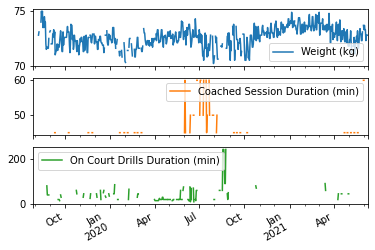

In [8]:
plot_cols = ['Weight (kg)', 'Coached Session Duration (min)',
             'On Court Drills Duration (min)']
plot_features = agr_df[plot_cols]
_ = plot_features.plot(subplots=True)

Let's clean up the table a little more, by getting rid of non-essential columns and replacing *NaN* values either by interpolation (for missing "Weight" values) or with 0 (elsewhere).

In [9]:
df = agr_df.drop(
    columns=[c for c in agr_df.columns if 'Played' in c or 'Won' in c or 'Intensity' in c or 'Bike' in c])
    #columns=[c for c in agr_df.columns if 'Played' in c or 'Won' in c or 'Bike' in c])
df['Weight (kg)'] = df['Weight (kg)'].interpolate()
df = df.fillna(0)
df.head()

,Weight (kg),Coached Session Duration (min),Full Body Duration (min),Ghosting Duration (min),On Court Drills Duration (min),Running Duration (min),Very Favoured Games Duration (min),Favoured Games Duration (min),Equally Favoured Games Duration (min),Unfavoured Games Duration (min),Very Unfavoured Games Duration (min),Unpredictable Games Duration (min)
2019-07-29,73.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0
2019-07-30,72.981818,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-31,72.963636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,15.0,0.0
2019-08-01,72.945455,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-08-02,72.927273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0


In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Weight (kg),682.0,72.592375,0.896140,70.2,72.0,72.6,73.2,75.0
Coached Session Duration (min),682.0,8.365103,18.122284,0.0,0.0,0.0,0.0,60.0
Full Body Duration (min),682.0,7.045455,13.598047,0.0,0.0,0.0,0.0,90.0
Ghosting Duration (min),682.0,3.269795,8.465908,0.0,0.0,0.0,0.0,40.0
On Court Drills Duration (min),682.0,11.847507,27.151128,0.0,0.0,0.0,15.0,240.0
Running Duration (min),682.0,6.605572,13.870436,0.0,0.0,0.0,0.0,60.0
Very Favoured Games Duration (min),682.0,0.623167,4.908884,0.0,0.0,0.0,0.0,65.0
Favoured Games Duration (min),682.0,3.079179,11.622029,0.0,0.0,0.0,0.0,90.0
Equally Favoured Games Duration (min),682.0,2.067449,9.463191,0.0,0.0,0.0,0.0,70.0
Unfavoured Games Duration (min),682.0,4.611437,14.643188,0.0,0.0,0.0,0.0,110.0


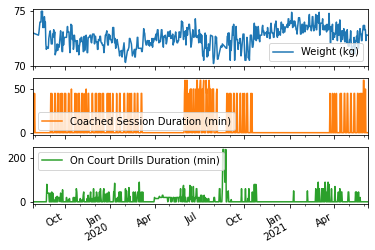

In [11]:
plot_cols = ['Weight (kg)', 'Coached Session Duration (min)',
             'On Court Drills Duration (min)']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True)

Since we are going to teach models to predict weight, we can assume there may be same weekly seasonality in play. We add two extra columns to signal that (following the [approach of the original tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series#time)).

In [12]:
timestamp_d = df.index.map(datetime.datetime.timestamp) / (60 * 60 * 24)
df['Day of Week Sin'] = np.sin(timestamp_d * (2 * np.pi / 7))
df['Day of Week Cos'] = np.cos(timestamp_d * (2 * np.pi / 7))


Text(0.5, 1.0, 'Day of Week signal')

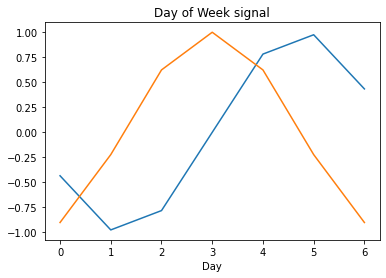

In [13]:
plt.plot(np.array(df['Day of Week Sin'])[:7])
plt.plot(np.array(df['Day of Week Cos'])[:7])
plt.xlabel('Day')
plt.title('Day of Week signal')

### Split and Normalize

(See https://www.tensorflow.org/tutorials/structured_data/time_series#split_the_data)

In [14]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [15]:
train_mean = train_df.mean()
train_std = train_df.std()

if NORMALIZE:
    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std

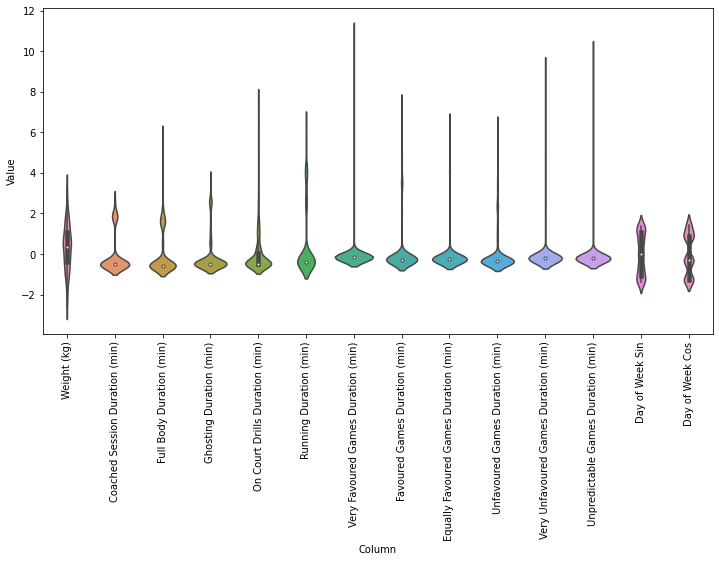

In [16]:
if NORMALIZE:
    df_std = (df - train_mean) / train_std
else:
    df_std = df.copy()

df_std = df_std.melt(var_name='Column',
                     value_name='Value')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Value', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

### Data Windowing

(See https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing)

In [17]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [18]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [19]:
def plot(self, model=None, plot_col='Weight (kg)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col}{" [normed]" if NORMALIZE else ""}')
    plt.plot(self.input_indices, inputs[-n-1, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[-n-1, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[-n-1, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Day')

WindowGenerator.plot = plot

In [20]:
def make_dataset(self, data, shuffle=True):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=shuffle,
      batch_size=BATCH_SIZE)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [21]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df, shuffle=False)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get the most recent one from the
    # `.test` dataset
    result = None
    for result in iter(self.test):
        pass
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

### Models Creation, Training and Testing

#### Helper Functions

Here's the function for training the models:

In [22]:
def compile_and_fit(model, window, patience=TRAIN_PATIENCE):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Being the test data frame unshaffled, running a model on it's last rows returns the prediction for the next day:

In [23]:
def predict_next_weight(model):
    pred = np.array(model(np.array([test_df[-21:]]))).flatten()
    return pred[-1] * train_std['Weight (kg)'] + train_mean['Weight (kg)']

#### Baseline Model

(See https://www.tensorflow.org/tutorials/structured_data/time_series#baseline)

In [24]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Weight (kg)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Weight (kg)']

In [25]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 14)
Labels shape (batch, time, features): (32, 1, 1)


In [26]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [27]:
baseline = Baseline(label_index=column_indices['Weight (kg)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
prediction = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
prediction['Baseline'] = predict_next_weight(baseline)

5/5 [==============================] - 0s 2ms/step - loss: 0.5256 - mean_absolute_error: 0.5242


In [28]:
wide_window = WindowGenerator(
    input_width=21, label_width=21, shift=1,
    label_columns=['Weight (kg)'])

wide_window

Total window size: 22
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Label column name(s): ['Weight (kg)']

In [29]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (16, 21, 14)
Output shape: (16, 21, 1)


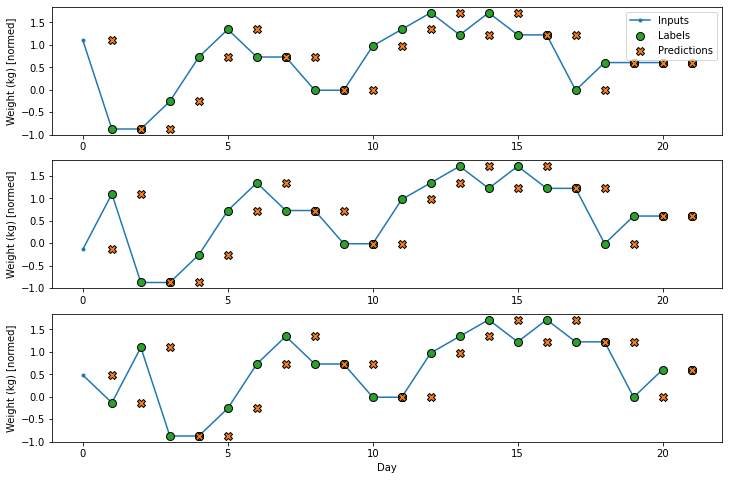

In [30]:
wide_window.plot(baseline)

#### Linear Model

(See https://www.tensorflow.org/tutorials/structured_data/time_series#linear_model)

In [31]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [32]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (4, 1, 14)
Output shape: (4, 1, 1)


In [33]:
history = compile_and_fit(linear, single_step_window)

IPython.display.clear_output()
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)
prediction['Linear'] = predict_next_weight(linear)

5/5 [==============================] - 0s 2ms/step - loss: 0.4272 - mean_absolute_error: 0.5209


In [34]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (16, 21, 14)
Output shape: (16, 21, 1)


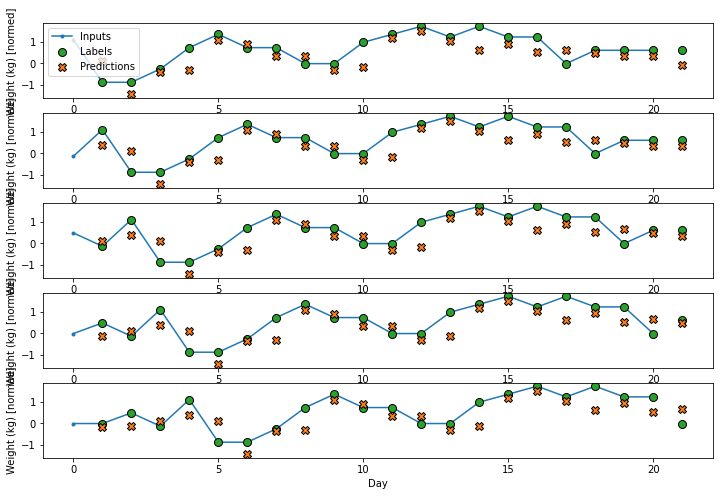

In [35]:
wide_window.plot(linear, max_subplots=5)

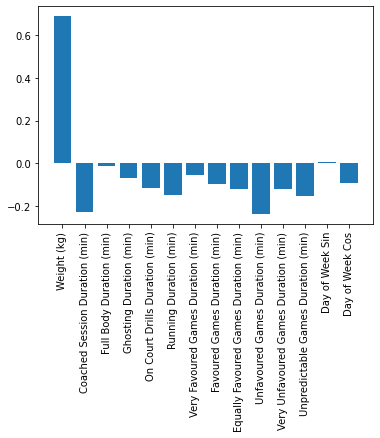

In [36]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

#### Multi-layer Dense Network Model

(See https://www.tensorflow.org/tutorials/structured_data/time_series#dense)

In [37]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=MODEL_SIZE, activation='relu'),
    tf.keras.layers.Dense(units=MODEL_SIZE, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)
prediction['Dense'] = predict_next_weight(dense)

5/5 [==============================] - 0s 3ms/step - loss: 0.5917 - mean_absolute_error: 0.6325


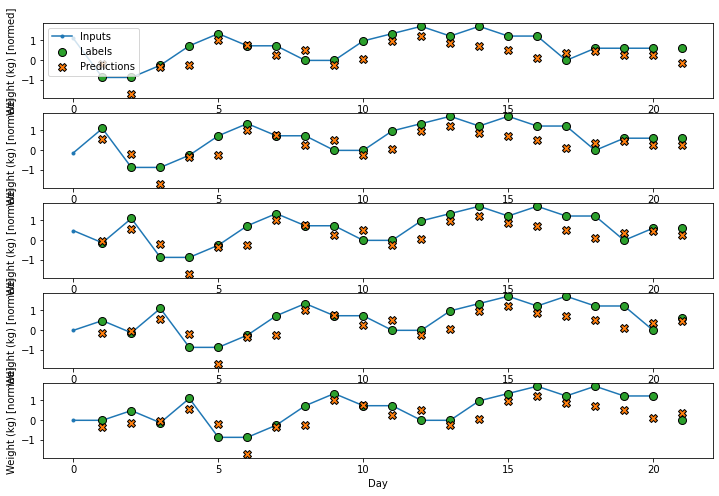

In [38]:
wide_window.plot(dense, max_subplots=5)

#### Convolutional Network Model

(See https://www.tensorflow.org/tutorials/structured_data/time_series#convolution_neural_network)

In [39]:
CONV_WIDTH = 21
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Weight (kg)'])

conv_window

Total window size: 22
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Label indices: [21]
Label column name(s): ['Weight (kg)']

Text(0.5, 1.0, 'Given 21 days as input, predict 1 day into the future.')

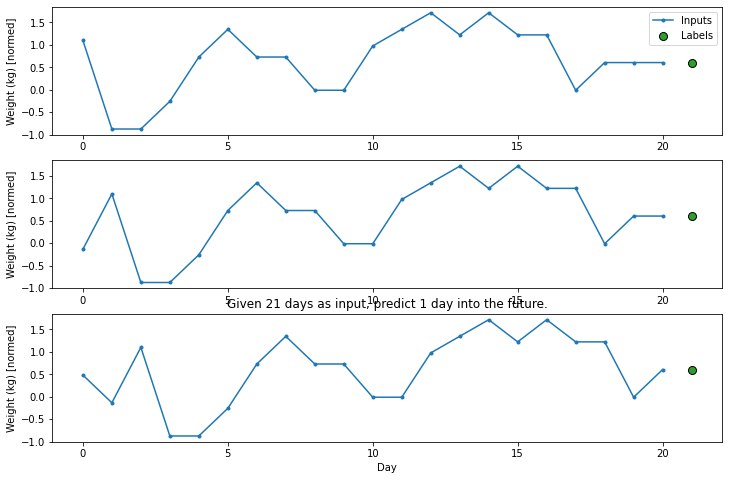

In [40]:
conv_window.plot()
plt.title("Given 21 days as input, predict 1 day into the future.")

In [41]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=MODEL_SIZE,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=MODEL_SIZE, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [42]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (16, 21, 14)
Output shape: (16, 1, 1)


In [43]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)
prediction['Conv'] = predict_next_weight(conv_model)

4/4 [==============================] - 0s 3ms/step - loss: 0.5612 - mean_absolute_error: 0.5978


In [44]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (16, 21, 14)
Labels shape: (16, 21, 1)
Output shape: (16, 1, 1)


In [45]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Weight (kg)'])

wide_conv_window

Total window size: 45
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
Label indices: [21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
Label column name(s): ['Weight (kg)']

In [46]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (25, 44, 14)
Labels shape: (25, 24, 1)
Output shape: (25, 24, 1)


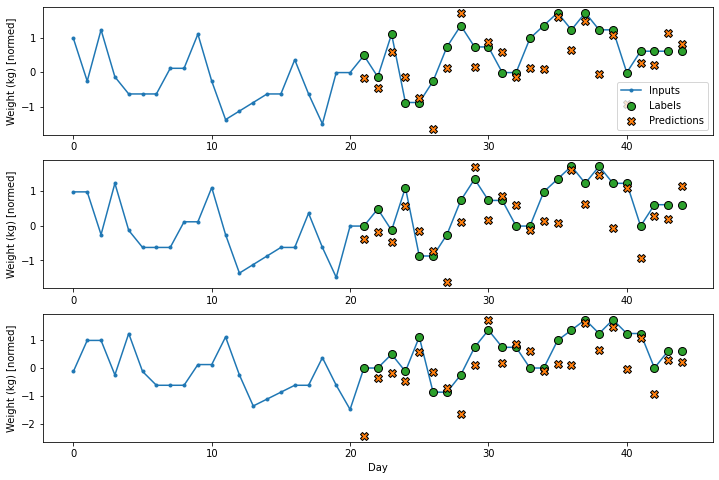

In [47]:
wide_conv_window.plot(conv_model)

#### Recurrent Neural Network Model

(See https://www.tensorflow.org/tutorials/structured_data/time_series#recurrent_neural_network)

In [48]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    #tf.keras.layers.LSTM(MODEL_SIZE, return_sequences=True),
    tf.keras.layers.LSTM(16, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [49]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (16, 21, 14)
Output shape: (16, 21, 1)


In [50]:
history = compile_and_fit(lstm_model, wide_window, patience=5)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
prediction['LSTM'] = predict_next_weight(lstm_model)

4/4 [==============================] - 0s 4ms/step - loss: 0.6742 - mean_absolute_error: 0.6712


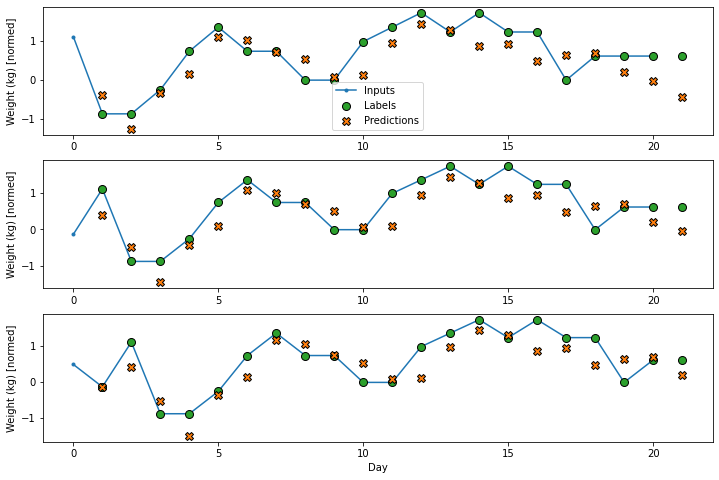

In [51]:
wide_window.plot(lstm_model)

### Performance Comparison

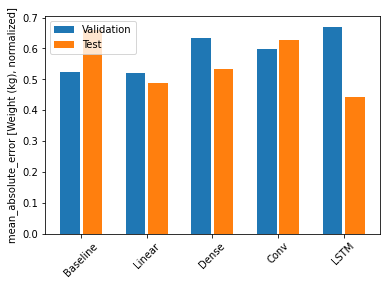

In [52]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel(f'mean_absolute_error [Weight (kg){", normalized]" if NORMALIZE else "]"}')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [53]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.6612
Linear      : 0.4876
Dense       : 0.5324
Conv        : 0.6267
LSTM        : 0.4413


### Tomorrow's Weight Prediction

In [54]:
tomorrow = test_df.index[-1] + datetime.timedelta(days=1)
print(f'Predictions for {tomorrow.strftime("%b %d, %Y")}:')
for name, value in prediction.items():
  print(f'{name:12s}: {value:0.4f}')

Predictions for Jun 10, 2021:
Baseline    : 72.8000
Linear      : 72.9583
Dense       : 73.0433
Conv        : 73.2472
LSTM        : 72.6693
